# Klassificering av hjärt- och kärlsjukdom

### Features:

- Age | Objective Feature | age | int (days)  
- Height | Objective Feature | height | int (cm) |  
- Weight | Objective Feature | weight | float (kg) |  
- Gender | Objective Feature | gender | categorical code |  
- Systolic blood pressure | Examination Feature | ap_hi | int |  
- Diastolic blood pressure | Examination Feature | ap_lo | int |  
- Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |  
- Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |  
- Smoking | Subjective Feature | smoke | binary |  
- Alcohol intake | Subjective Feature | alco | binary |  
- Physical activity | Subjective Feature | active | binary |  

## 1.2 Modelldesign

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("cardio_train.csv", delimiter=";", index_col=0)
df.head(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


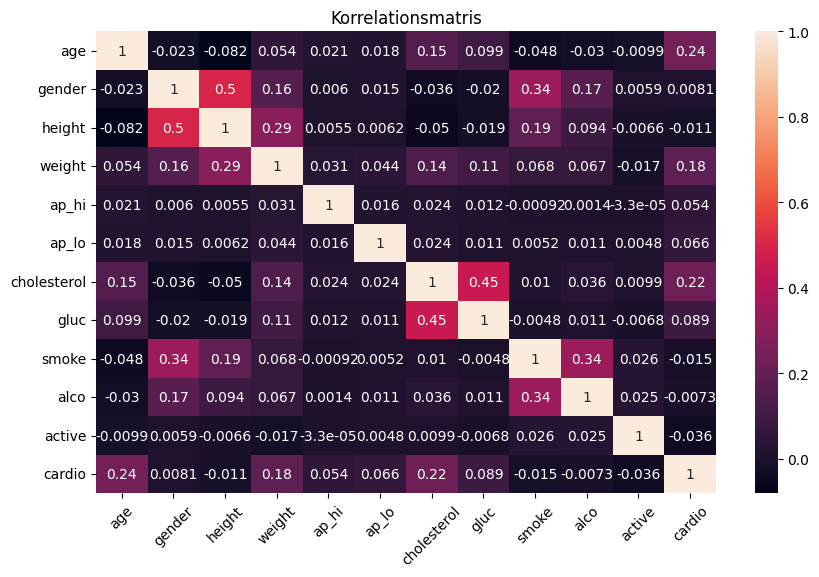

In [4]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True)
plt.xticks(rotation=45)
plt.title('Korrelationsmatris')
plt.show()

### Korrelationer:
- **Age:** cholesterol (0.15), cardio (0.24)  
- **Gender:** height (0.5), weight (0.16), smoke (0.34), alco (0.17)  
- **Height:** gender (0.5), weight (0.29), smoke (0.19)  
- **Weight:** gender (0.16), height (0.29), cholesterol (0.14), gluc (0.11), cardio (0.18)  
- **Ap_hi:** inga  
- **AP_lo:** inga  
- **Cholesterol:** age (0.15), weight (0.14), gluc (0.45), cardio (0.22)  
- **Gluc:** weight (0.11), cholesterol (0.45)  
- **Smoke:** gender (0.34), height (0.19), alco (0.34)  
- **Alco:** gender (0.17), smoke (0.34)  
- **Active:** inga  
- **Cardio:** age (0.24), weight (0.18), cholesterol (0.22)  

##### Tillägg 1:

- **BMI:** age (0.11), weight (0.85), cholesterol (0.17),, gluc (0.12), cardio (0.2), BMI category rating (0.95)  
- **BMI category rating:** weight (0.81), cholesterol (0.17), gluc (0.11), cardio (0.18), BMI (0.95)

##### Tillägg 2:

- **Blood pressure rating**: age (0.19), weight (0.24), ap_hi (0.72), ap_lo (0.81), cholesterol (0.14), cardio (0.34), BMI (0.22), BMI category (0.19)

### 1.2.1 Feature Engineering
Skapa en feature för BMI  
BMI = vikt / längd^2

In [5]:
# Gör om längd från centimeter till meter
df["height"] = df["height"] * 0.01

df["BMI"] = df["weight"] / (df["height"] ** 2)
df.head(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
id,,,,,,,,,,,,,
0,18393,2,1.68,62.0,110,80,1,1,0,0,1,0,21.967120
1,20228,1,1.56,85.0,140,90,3,1,0,0,1,1,34.927679
2,18857,1,1.65,64.0,130,70,3,1,0,0,0,1,23.507805
3,17623,2,1.69,82.0,150,100,1,1,0,0,1,1,28.710479
4,17474,1,1.56,56.0,100,60,1,1,0,0,0,0,23.011177


a) Släng de samples med orimliga BMIer och outliers.

**[WHO](https://www.who.int/data/gho/data/themes/topics/topic-details/GHO/body-mass-index)**'s guidelines är:

**Underviktig**: Under 18.5  
**Normal vikt**: 18.5 till 24.9  
**Överviktig**: 25 till 29.9  
**Sjukligt överviktig**: 30 och över  

Enligt [National Library of Medicine](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8837073/) klassificeras extrema fall av anorexia nervosa som de med BMI under 15 men nämner fall där BMI för anorexiker ligger så lågt som 9.  
**Jag sätter därför nedre gränsen som 9**.  

Enligt [Centers for Disease Control and Prevention](https://www.cdc.gov/obesity/basics/adult-defining.html) finns det 3 klasser av sjukligt överviktig där klass 3, 40 och högre, kategoriseras som extremt.  
För nedre gränsen valde jag 6 lägre än extremfall så det känns rimligt att göra det samma med övervikt.  
**Jag sätter därför övre gränsen som 46**.

In [6]:
# a)
df = df[(df["BMI"] >= 9) & (df["BMI"] <= 46)]

b) Skapa en kategorisk BMI-feature med kategorierna: normal range, over-weight, obese (class I), obese (class II), obese (class III)

[Centers for Disease Control and Prevention](https://www.cdc.gov/obesity/basics/adult-defining.html) satte klass 1 som 30 till < 35, klass 2 som 35 till < 40 och klass 3 som 40 eller över så jag följer det.

In [7]:
# b)
kategorier = ["Normal range", "Over-weight", "Obese (class I)", "Obese (class II)", "Obese (class III)"]
intervaller = [18.5, 25, 30, 35, 40, float("inf")]     # Tog hjälp av ChatGPT för att hitta float("inf")

df["BMI category"] = pd.cut(df["BMI"], bins=intervaller, labels=kategorier)

c) Undersök om kategorin är relevant, dvs dess korrelationer.

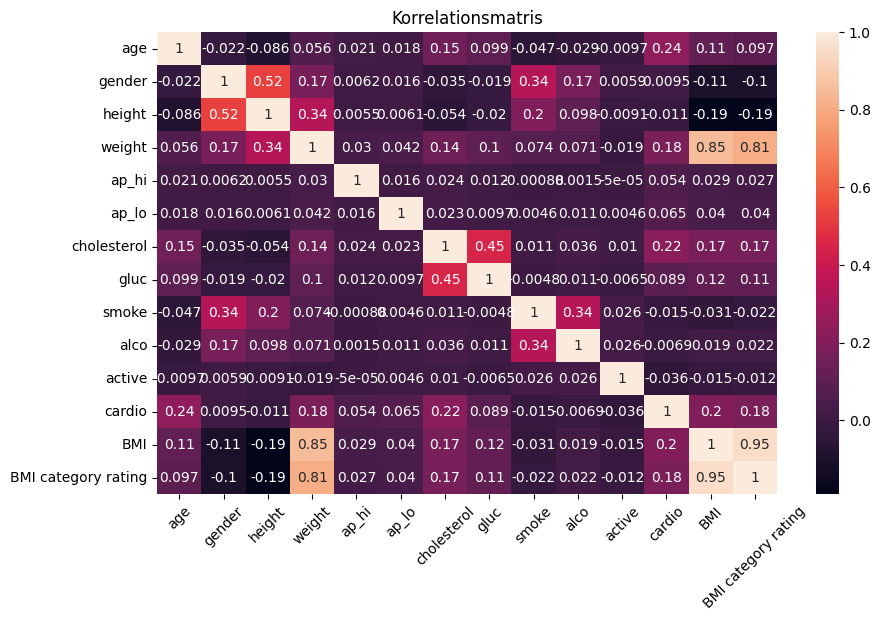

In [8]:
# c)
rating_dict = {"Normal range": 1, "Over-weight": 2, "Obese (class I)": 3, "Obese (class II)": 4, "Obese (class III)": 5}

df["BMI category rating"] = df["BMI category"].map(rating_dict)
ny_df = df.drop('BMI category', axis=1)

plt.figure(figsize=(10,6))
sns.heatmap(ny_df.corr(), annot=True)
plt.xticks(rotation=45)
plt.title('Korrelationsmatris')
plt.show()

Skapa en feature för blodtryckskategorier enligt tabellen i denna [artikel (healthline)](https://www.healthline.com/health/high-blood-pressure-hypertension).

### Blood Pressure Ranges

| BLOOD PRESSURE CATEGORY | SYSTOLIC (mm Hg) | DIASTOLIC (mm Hg) |
|-------------------------|------------------|-------------------|
| Healthy                 | less than 120    | and less than 80  |
| Elevated                | 120–129          | and less than 80  |
| Stage 1 hypertension    | 130–139          | or 80–89          |
| Stage 2 hypertension    | 140 or higher    | or 90 or higher   |
| Hypertension crisis     | over 180         | or over 120       |

<br>

- Systolic blodtryck = kolumnen "ap_hi"
- Diastolic blodtryck = kolumnen "ap_lo"

a) Släng bort samples med orimliga blodtryck och outliers.

För BMI så satte jag nedre gränsen som 9, ca 50% under normal (nedre gräns normal = 18.5). Jag satte övre gränsen som 46, ca 15% över sjukligt (40). Jag väljer att göra det samma för blodtryck vilket ger:  

- Systolic blodtryck nedre gräns = 0.5 * 120 = 60
- Systolic blodtryck övre gräns = 1.15 * 180 = 207 (avrundar uppåt till 210)
- Diastolic blodtryck nedre gräns = 0.5 * 80 = 40
- Diastolic blodtryck övre gräns = 1.15 * 120 = 138 (avrundar uppåt till 140)

In [9]:
ny_df.head(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,BMI category rating
id,,,,,,,,,,,,,,
0,18393,2,1.68,62.0,110,80,1,1,0,0,1,0,21.967120,1
1,20228,1,1.56,85.0,140,90,3,1,0,0,1,1,34.927679,3
2,18857,1,1.65,64.0,130,70,3,1,0,0,0,1,23.507805,1
3,17623,2,1.69,82.0,150,100,1,1,0,0,1,1,28.710479,2
4,17474,1,1.56,56.0,100,60,1,1,0,0,0,0,23.011177,1


In [10]:
df.head(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,BMI category,BMI category rating
id,,,,,,,,,,,,,,,
0,18393,2,1.68,62.0,110,80,1,1,0,0,1,0,21.967120,Normal range,1
1,20228,1,1.56,85.0,140,90,3,1,0,0,1,1,34.927679,Obese (class I),3
2,18857,1,1.65,64.0,130,70,3,1,0,0,0,1,23.507805,Normal range,1
3,17623,2,1.69,82.0,150,100,1,1,0,0,1,1,28.710479,Over-weight,2
4,17474,1,1.56,56.0,100,60,1,1,0,0,0,0,23.011177,Normal range,1


In [11]:
# a)
df = df[(df["ap_hi"] >= 60) & (df["ap_hi"] <= 210) & (df["ap_lo"] >= 40) & (df["ap_lo"] <= 140)]

b) Skapa en kategorisk feature med relevanta kategorier.

In [12]:
# b)
def kategorisera_blodtryck(row):
    if row["ap_hi"] < 120 and row["ap_lo"] < 80:
        return "Healthy"
    elif 120 <= row["ap_hi"] < 130 and row["ap_lo"] < 80:
        return "Elevated"
    elif 130 <= row["ap_hi"] < 140 or 80 <= row["ap_lo"] < 90:
        return "Stage 1 hypertension"
    elif row["ap_hi"] >= 140 or row["ap_lo"] >= 90:
        return "Stage 2 hypertension"
    elif row["ap_hi"] > 180 or row["ap_lo"] < 120:
        return "Hypertension crisis"
    
df["blood pressure category"] = df.apply(kategorisera_blodtryck, axis=1)

In [13]:
df.head(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,BMI category,BMI category rating,blood pressure category
id,,,,,,,,,,,,,,,,
0,18393,2,1.68,62.0,110,80,1,1,0,0,1,0,21.967120,Normal range,1,Stage 1 hypertension
1,20228,1,1.56,85.0,140,90,3,1,0,0,1,1,34.927679,Obese (class I),3,Stage 2 hypertension
2,18857,1,1.65,64.0,130,70,3,1,0,0,0,1,23.507805,Normal range,1,Stage 1 hypertension
3,17623,2,1.69,82.0,150,100,1,1,0,0,1,1,28.710479,Over-weight,2,Stage 2 hypertension
4,17474,1,1.56,56.0,100,60,1,1,0,0,0,0,23.011177,Normal range,1,Healthy


In [14]:
ny_df.head(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,BMI category rating
id,,,,,,,,,,,,,,
0,18393,2,1.68,62.0,110,80,1,1,0,0,1,0,21.967120,1
1,20228,1,1.56,85.0,140,90,3,1,0,0,1,1,34.927679,3
2,18857,1,1.65,64.0,130,70,3,1,0,0,0,1,23.507805,1
3,17623,2,1.69,82.0,150,100,1,1,0,0,1,1,28.710479,2
4,17474,1,1.56,56.0,100,60,1,1,0,0,0,0,23.011177,1


c) Undersök om den nya kategorin är relevant, dvs har den någon nyttig korrelation?

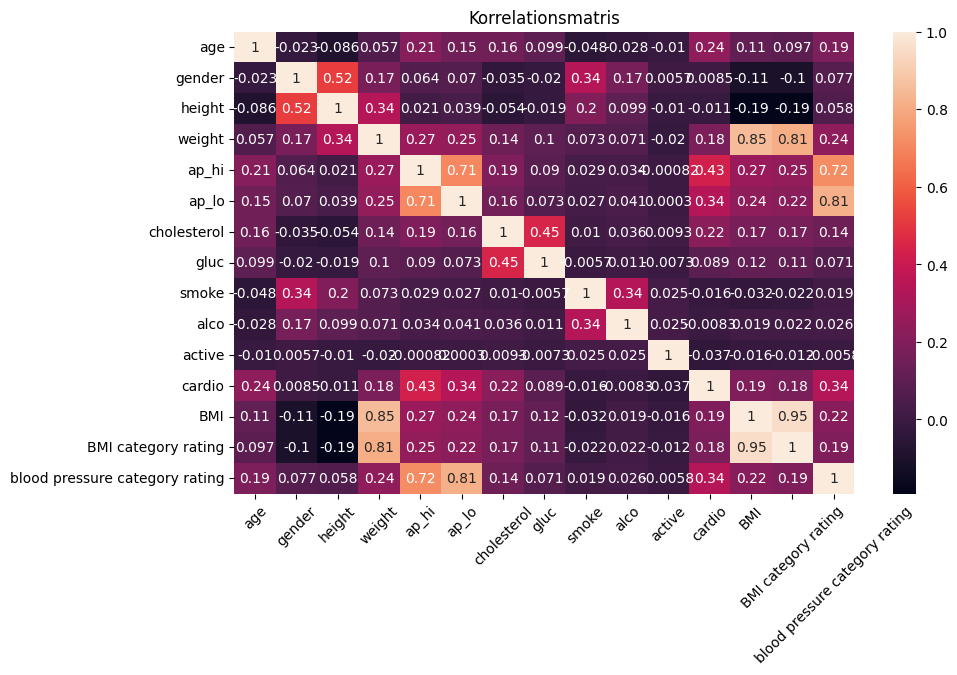

In [15]:
# c)
rating_dict = {"Healthy": 1, "Elevated": 2, "Stage 1 hypertension": 3, "Stage 2 hypertension": 4, "Hypertension crisis": 5}

df["blood pressure category rating"] = df["blood pressure category"].map(rating_dict)
ny_df = df.drop(columns=['BMI category', 'blood pressure category'], axis=1)

plt.figure(figsize=(10,6))
sns.heatmap(ny_df.corr(), annot=True)
plt.xticks(rotation=45)
plt.title('Korrelationsmatris')
plt.show()

In [16]:
# Ta bort rating kolumnerna eftersom de inte behövs (förutom för korrelationsanalys)
df = df.drop(columns=["BMI category rating", "blood pressure category rating"], axis=1)
df.head(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,BMI category,blood pressure category
id,,,,,,,,,,,,,,,
0,18393,2,1.68,62.0,110,80,1,1,0,0,1,0,21.967120,Normal range,Stage 1 hypertension
1,20228,1,1.56,85.0,140,90,3,1,0,0,1,1,34.927679,Obese (class I),Stage 2 hypertension
2,18857,1,1.65,64.0,130,70,3,1,0,0,0,1,23.507805,Normal range,Stage 1 hypertension
3,17623,2,1.69,82.0,150,100,1,1,0,0,1,1,28.710479,Over-weight,Stage 2 hypertension
4,17474,1,1.56,56.0,100,60,1,1,0,0,0,0,23.011177,Normal range,Healthy


In [17]:
# Kolla vilka kategorier som faktiskt förekommer
df["BMI category"].value_counts()

BMI category
Normal range         25454
Over-weight          24638
Obese (class I)      11945
Obese (class II)      4243
Obese (class III)     1305
Name: count, dtype: int64

In [18]:
df["blood pressure category"].value_counts()

blood pressure category
Stage 1 hypertension    39537
Stage 2 hypertension    16071
Healthy                  9526
Elevated                 3091
Name: count, dtype: int64

Intressant!! Det förekommer inga med ***hypertension crisis***.

### 1.2.2 Skapa två dataset

In [19]:
# Dataset 1
df_1 = df.copy()
df_1 = df_1.drop(columns=["ap_hi", "ap_lo", "height", "weight", "BMI"])

BMI_ohe = pd.get_dummies(df_1["BMI category"]).astype(int)
blodtryck_ohe = pd.get_dummies(df_1["blood pressure category"]).astype(int)
kön_ohe = pd.get_dummies(df_1["gender"], prefix="gender").astype(int)

kön_ohe = kön_ohe.rename(columns={"gender_1": "Female", "gender_2": "Male"})

df_1 = df_1.join(BMI_ohe)
df_1 = df_1.join(blodtryck_ohe)
df_1 = df_1.join(kön_ohe)

df_1 = df_1.drop(columns=["gender", "BMI category", "blood pressure category"])

df_1.head(5)

,age,cholesterol,gluc,smoke,alco,active,cardio,Normal range,Over-weight,Obese (class I),Obese (class II),Obese (class III),Elevated,Healthy,Stage 1 hypertension,Stage 2 hypertension,Female,Male
id,,,,,,,,,,,,,,,,,,
0,18393,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1
1,20228,3,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0
2,18857,3,1,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0
3,17623,1,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,1
4,17474,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0


In [20]:
# Dataset 2
df_2 = df.copy()
df_2 = df_2.drop(columns=["BMI category", "blood pressure category", "height", "weight"])

df_2 = df_2.join(kön_ohe)

df_2.head(5)

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,Female,Male
id,,,,,,,,,,,,,
0,18393,2,110,80,1,1,0,0,1,0,21.967120,0,1
1,20228,1,140,90,3,1,0,0,1,1,34.927679,1,0
2,18857,1,130,70,3,1,0,0,0,1,23.507805,1,0
3,17623,2,150,100,1,1,0,0,1,1,28.710479,0,1
4,17474,1,100,60,1,1,0,0,0,0,23.011177,1,0


## 1.2.3 Utförande

Jag kommer använda dessa algoritmerna:
- Logistic Regression
- Random Forest
- SVM

### Dataset 1

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

X, y = df_1.drop("cardio", axis=1), df_1["cardio"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistisk regression
pipeline_logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(solver='liblinear'))
])

param_grid_logreg = {
    "logreg__C": [0.01, 0.1, 1, 10, 100],
    "logreg__penalty": ["l1", "l2"]
}

grid_logreg = GridSearchCV(pipeline_logreg, param_grid_logreg, cv=5, scoring="accuracy", verbose=1)

grid_logreg.fit(X_train, y_train)

bästa_modell = grid_logreg.best_estimator_
bästa_parametrar = grid_logreg.best_params_
bäst_score = grid_logreg.best_score_

print(f"Bästa parametrar: {bästa_parametrar}")
print(f"Bästa cross-validation score: {bäst_score}")

test_score = bästa_modell.score(X_test, y_test)
print(f"Test score: {test_score}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Bästa parametrar: {'logreg__C': 0.1, 'logreg__penalty': 'l1'}
Bästa cross-validation score: 0.7004213997801393
Test score: 0.703774276291682


Bästa parametrar: {'logreg__C': 0.1, 'logreg__penalty': 'l1'}  
Bästa cross-validation score: 0.7004213997801393  
Test score: 0.703774276291682  

In [27]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'rf__n_estimators': [10, 50, 100],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring="accuracy", verbose=1)

grid_rf.fit(X_train, y_train)

bästa_modell = grid_rf.best_estimator_
bästa_parametrar = grid_rf.best_params_
bäst_score = grid_rf.best_score_

print(f"Bästa parametrar: {bästa_parametrar}")
print(f"Bästa cross-validation score: {bäst_score}")

test_score = bästa_modell.score(X_test, y_test)
print(f"Test score: {test_score}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Bästa parametrar: {'rf__max_depth': 10, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}
Bästa cross-validation score: 0.7021253206302676
Test score: 0.7062660315133749


Bästa parametrar: {'rf__max_depth': 10, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}  
Bästa cross-validation score: 0.7021253206302676  
Test score: 0.7062660315133749  

In [ ]:
# SVM
from sklearn.svm import SVC

pipeline_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(random_state=42))
])

param_grid_svm = {
    "svm__C": [0.1, 1, 10],
    "svm__kernel": ["linear", "rbf"],
    "svm__gamma": ["scale", "auto"]
}

grid_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, scoring="accuracy", verbose=1)

grid_svm.fit(X_train, y_train)

bästa_modell = grid_svm.best_estimator_
bästa_parametrar = grid_svm.best_params_
bäst_score = grid_svm.best_score_

print(f"Bästa parametrar: {bästa_parametrar}")
print(f"Bästa cross-validation score: {bäst_score}")

test_score = bästa_modell.score(X_test, y_test)
print(f"Test score: {test_score}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Bästa parametrar: {'svm__C': 1, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Bästa cross-validation score: 0.699725174056431
Test score: 0.7056064492488091


Bästa parametrar: {'svm__C': 1, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}  
Bästa cross-validation score: 0.699725174056431  
Test score: 0.7056064492488091  

### Dataset 2

In [28]:
# Logistisk regression
X, y = df_2.drop("cardio", axis=1), df_2["cardio"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline_logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(solver='liblinear'))
])

param_grid_logreg = {
    "logreg__C": [0.01, 0.1, 1, 10, 100],
    "logreg__penalty": ["l1", "l2"]
}

grid_logreg = GridSearchCV(pipeline_logreg, param_grid_logreg, cv=5, scoring="accuracy", verbose=1)

grid_logreg.fit(X_train, y_train)

bästa_modell = grid_logreg.best_estimator_
bästa_parametrar = grid_logreg.best_params_
bäst_score = grid_logreg.best_score_

print(f"Bästa parametrar: {bästa_parametrar}")
print(f"Bästa cross-validation score: {bäst_score}")

test_score = bästa_modell.score(X_test, y_test)
print(f"Test score: {test_score}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Bästa parametrar: {'logreg__C': 0.1, 'logreg__penalty': 'l1'}
Bästa cross-validation score: 0.7269329424697691
Test score: 0.7298644192011726


Bästa parametrar: {'logreg__C': 0.1, 'logreg__penalty': 'l1'}  
Bästa cross-validation score: 0.7269329424697691  
Test score: 0.7298644192011726  

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'rf__n_estimators': [10, 50, 100],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring="accuracy", verbose=1)

grid_rf.fit(X_train, y_train)

bästa_modell = grid_rf.best_estimator_
bästa_parametrar = grid_rf.best_params_
bäst_score = grid_rf.best_score_

print(f"Bästa parametrar: {bästa_parametrar}")
print(f"Bästa cross-validation score: {bäst_score}")

test_score = bästa_modell.score(X_test, y_test)
print(f"Test score: {test_score}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Bästa parametrar: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 50}
Bästa cross-validation score: 0.733272260901429
Test score: 0.7365335287651155


Bästa parametrar: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 50}  
Bästa cross-validation score: 0.733272260901429  
Test score: 0.7365335287651155  

In [ ]:
# SVM
from sklearn.svm import SVC

pipeline_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(random_state=42))
])

param_grid_svm = {
    "svm__C": [0.1, 1, 10],
    "svm__kernel": ["linear", "rbf"],
    "svm__gamma": ["scale", "auto"]
}

grid_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, scoring="accuracy", verbose=1)

grid_svm.fit(X_train, y_train)

bästa_modell = grid_svm.best_estimator_
bästa_parametrar = grid_svm.best_params_
bäst_score = grid_svm.best_score_

print(f"Bästa parametrar: {bästa_parametrar}")
print(f"Bästa cross-validation score: {bäst_score}")

test_score = bästa_modell.score(X_test, y_test)
print(f"Test score: {test_score}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Bästa parametrar: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Bästa cross-validation score: 0.7318431659948699
Test score: 0.736093807255405


Bästa parametrar: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}  
Bästa cross-validation score: 0.7318431659948699  
Test score: 0.736093807255405  

## Resultat

### Dataset 1

**Logistisk regression:**  
- Bästa cross-validation score: 0.7004213997801393
- Test score: 0.703774276291682  

**Random forest:**  
- Bästa cross-validation score: 0.7021253206302676
- Test score: 0.7062660315133749  

**SVM:**  
- Bästa cross-validation score: 0.699725174056431
- Test score: 0.7056064492488091

### Dataset 2

**Logistisk regression:** 
- Bästa cross-validation score: 0.7269329424697691
- Test score: 0.7298644192011726

**Random forest:**
- Bästa cross-validation score: 0.733272260901429
- Test score: 0.7365335287651155

**SVM:** 0.7360938072554050
- Bästa cross-validation score: 0.7318431659948699
- Test score: 0.736093807255405

### Slutsats

Dataset 2 med random forest algoritmen gav bäst resultat (både cross-validation score och test score).

**Bästa parametrar:** 
- max_depth: 10
- min_samples_split: 5
- n_estimators: 50

Jag testar parametrar där jag tar värdet mellan högsta/lägsta av de tidigare värdena som nedre och övre gräns för att se om jag kan optimera parametrarna.  
T.ex n_estimators blir nu [30, 50, 75] istället för [10, 50, 100] (30 ligger mellan 10 & 50, 75 ligger mellan 50 & 100).


In [38]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'rf__n_estimators': [30, 50, 75],   
    'rf__max_depth': [5, 10, 15], 
    'rf__min_samples_split': [4, 5, 7]  
}

grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring="accuracy", verbose=1)

grid_rf.fit(X_train, y_train)

bästa_modell = grid_rf.best_estimator_
bästa_parametrar = grid_rf.best_params_
bäst_score = grid_rf.best_score_

print(f"Bästa parametrar: {bästa_parametrar}")
print(f"Bästa cross-validation score: {bäst_score}")

test_score = bästa_modell.score(X_test, y_test)
print(f"Test score: {test_score}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Bästa parametrar: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 30}
Bästa cross-validation score: 0.7334554781971419
Test score: 0.7357273726639795


Ursprungligen:

Bästa parametrar: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 50}  
Bästa cross-validation score: 0.733272260901429  
Test score: 0.7365335287651155  

Nu:  

Bästa parametrar: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 30}  
Bästa cross-validation score: 0.7334554781971419  
Test score: 0.7357273726639795  

Intressant. Test score var lägre denna gången men cross-validation score var lite högre.  
Jag provar att fortsätta och ser vad det ger för resultat.  

In [45]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'rf__n_estimators': [20, 30, 40],   
    'rf__max_depth': [8, 10, 12], 
    'rf__min_samples_split': [5, 6]  # Tar bort 4 eftersom 5 var bättre
}

grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring="accuracy", verbose=1)

grid_rf.fit(X_train, y_train)

bästa_modell = grid_rf.best_estimator_
bästa_parametrar = grid_rf.best_params_
bäst_score = grid_rf.best_score_

print(f"Bästa parametrar: {bästa_parametrar}")
print(f"Bästa cross-validation score: {bäst_score}")

test_score = bästa_modell.score(X_test, y_test)
print(f"Test score: {test_score}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Bästa parametrar: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 30}
Bästa cross-validation score: 0.7334554781971419
Test score: 0.7357273726639795


Samma resultat som förra. Jag fortsätter.  

In [46]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'rf__n_estimators': [25, 30, 35],   
    'rf__max_depth': [9, 10, 11],   
    'rf__min_samples_split': [5] # Tar bort 6 eftersom 5 var bättre
}

grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring="accuracy", verbose=1)

grid_rf.fit(X_train, y_train)

bästa_modell = grid_rf.best_estimator_
bästa_parametrar = grid_rf.best_params_
bäst_score = grid_rf.best_score_

print(f"Bästa parametrar: {bästa_parametrar}")
print(f"Bästa cross-validation score: {bäst_score}")

test_score = bästa_modell.score(X_test, y_test)
print(f"Test score: {test_score}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Bästa parametrar: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 35}
Bästa cross-validation score: 0.7335470868449981
Test score: 0.734408208134848


Intressant. Cross-validation score ökar medan test score sjunker.  
n_estimators högsta värde bör vara 35, eftersom den visade att 30 var bättre än 40. Den visade nu 35, så det nya intervallet bör vara mellan 33 - 35

Jag fortsätter.

In [47]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'rf__n_estimators': [33, 34, 35],   
    'rf__max_depth': [10],   
    'rf__min_samples_split': [5] 
}

grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring="accuracy", verbose=1)

grid_rf.fit(X_train, y_train)

bästa_modell = grid_rf.best_estimator_
bästa_parametrar = grid_rf.best_params_
bäst_score = grid_rf.best_score_

print(f"Bästa parametrar: {bästa_parametrar}")
print(f"Bästa cross-validation score: {bäst_score}")

test_score = bästa_modell.score(X_test, y_test)
print(f"Test score: {test_score}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Bästa parametrar: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 33}
Bästa cross-validation score: 0.7336386954928545
Test score: 0.734481495053133


Okej så de bästa parametrarna är alltså:
- _max_depth = 10
- _min_samples_split = 5
- _n_estimators = 33

Dessa ger:

Bästa cross-validation score: 0.7336386954928545  
Test score: 0.734481495053133  

Jämfört med ursprungligen:

Bästa cross-validation score: 0.733272260901429  
Test score: 0.7365335287651155 

Cross-validation score är snäppet högre medan test score är snäppet lägre.

**Men!** Förut tänkte jag fel när jag optimiserade (gjorde om nu) och av någon anledning gav det bättre resultat. Istället för 30, 40, 50 så satte jag 50, 62, 75 (tror jag läste 30 som 50).
Jag vill fortsätta och se vad det ger för resultat i slutändan.

In [62]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'rf__n_estimators': [50, 62, 75],
    'rf__max_depth': [10],  
    'rf__min_samples_split': [5] 
}

grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring="accuracy", verbose=1)

grid_rf.fit(X_train, y_train)

bästa_modell = grid_rf.best_estimator_
bästa_parametrar = grid_rf.best_params_
bäst_score = grid_rf.best_score_

print(f"Bästa parametrar: {bästa_parametrar}")
print(f"Bästa cross-validation score: {bäst_score}")

test_score = bästa_modell.score(X_test, y_test)
print(f"Test score: {test_score}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Bästa parametrar: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 62}
Bästa cross-validation score: 0.733675338951997
Test score: 0.7358739465005496


In [63]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'rf__n_estimators': [56, 62, 68],
    'rf__max_depth': [10],  
    'rf__min_samples_split': [5] 
}

grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring="accuracy", verbose=1)

grid_rf.fit(X_train, y_train)

bästa_modell = grid_rf.best_estimator_
bästa_parametrar = grid_rf.best_params_
bäst_score = grid_rf.best_score_

print(f"Bästa parametrar: {bästa_parametrar}")
print(f"Bästa cross-validation score: {bäst_score}")

test_score = bästa_modell.score(X_test, y_test)
print(f"Test score: {test_score}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Bästa parametrar: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 68}
Bästa cross-validation score: 0.7337486258702822
Test score: 0.7368266764382557


In [64]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'rf__n_estimators': [62, 65, 68],
    'rf__max_depth': [10],  
    'rf__min_samples_split': [5] 
}

grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring="accuracy", verbose=1)

grid_rf.fit(X_train, y_train)

bästa_modell = grid_rf.best_estimator_
bästa_parametrar = grid_rf.best_params_
bäst_score = grid_rf.best_score_

print(f"Bästa parametrar: {bästa_parametrar}")
print(f"Bästa cross-validation score: {bäst_score}")

test_score = bästa_modell.score(X_test, y_test)
print(f"Test score: {test_score}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Bästa parametrar: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 68}
Bästa cross-validation score: 0.7337486258702822
Test score: 0.7368266764382557


In [67]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'rf__n_estimators': [66, 67, 68],
    'rf__max_depth': [10],  
    'rf__min_samples_split': [5] 
}

grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring="accuracy", verbose=1)

grid_rf.fit(X_train, y_train)

bästa_modell = grid_rf.best_estimator_
bästa_parametrar = grid_rf.best_params_
bäst_score = grid_rf.best_score_

print(f"Bästa parametrar: {bästa_parametrar}")
print(f"Bästa cross-validation score: {bäst_score}")

test_score = bästa_modell.score(X_test, y_test)
print(f"Test score: {test_score}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Bästa parametrar: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 68}
Bästa cross-validation score: 0.7337486258702822
Test score: 0.7368266764382557


### Resultat

**Ursprungligen:**  

Bästa parametrar: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 50}  
Bästa cross-validation score: 0.733272260901429  
Test score: 0.7365335287651155  

**Optimerad:**  

Bästa parametrar: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 33}  
Bästa cross-validation score: 0.7336386954928545  
Test score: 0.734481495053133  

**Feloptimerad:**  

Bästa parametrar: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 68}  
Bästa cross-validation score: 0.7337486258702822  
Test score: 0.7368266764382557  

### Analys

Väldigt intressanta resultat. 
- När jag optimerade rätt så blev cross-validation score högre än ursprungligen medan test score blev lägre.  
- När jag optimerade fel så blev både cross-validation score och test score högre än ursprungligen **och** när jag optimerade rätt.  

### Slutsats

*Jag väljer att gå med de feloptimerade parametrarna av den anledningen att de gav bäst resultat.*